### Imports

In [1]:
from rich.traceback import install; install()
%load_ext autoreload
%autoreload 2

import sys; sys.path.append(2*'../')

import torch

import matplotlib.pyplot as plt

from matplotlib import cm

from rl4co.envs import TSPEnv, CVRPEnv, SHPPEnv
from rl4co.models.zoo import (
    AttentionModel,
    AttentionModelPolicy,
    GLOP,
    GLOPPolicy,
)
from rl4co.utils.trainer import RL4COTrainer
from rl4co.utils.ops import batchify, gather_by_index

/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/torchrl/data/replay_buffers/samplers.py:36: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)
/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train/Load multi SHPP Revisers

In [2]:
# env = SHPPEnv(generator_params={"num_loc": 20}) 

# embed_dim = 128

# policy = AttentionModelPolicy(
#     embed_dim=embed_dim,
#     env_name=env.name,
# )

# reviser = AttentionModel(
#     env, 
#     policy,
#     baseline="rollout",
#     train_data_size=100_000,
#     val_data_size=10_000,
#     optimizer_kwargs={"lr": 1e-4},
# )

# trainer = RL4COTrainer(
#     max_epochs=3,
#     accelerator="gpu",
#     devices=1,
#     logger=None,
# )

# trainer.fit(reviser)
# reviser_list = [reviser]

In [3]:
# Load revisers from checkpoint
reviser_root_path = "../../checkpoints/"
reviser_size_list = [10]

env_list = []
reviser_list = []
for reviser_idx, reviser_size in enumerate(reviser_size_list):
    env = SHPPEnv(generator_params={"num_loc": reviser_size}) 

    embed_dim = 128

    policy = AttentionModelPolicy(
        embed_dim=embed_dim,
        env_name=env.name,
    )

    reviser = AttentionModel(
        env,
        policy,
        baseline="rollout",
        train_data_size=100_000,
        val_data_size=10_000,
        optimizer_kwargs={"lr": 1e-4},
    ) 
    reviser.load_from_checkpoint(reviser_root_path + f"{reviser_size}.ckpt")

    env_list.append(env)
    reviser_list.append(reviser)

/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['baseline.baseline.policy.encoder.init_embedding.init_embed.weight', 'baseline.baseline.policy.encoder.init_embedding.init_embed.bias', 'baseline.baseline.policy.encoder.init_embedding.init_embed_start.weight', 'baseline.baseline.policy.enc

### Test greedy rollout with untrained model and plot

In [4]:
# Parameters
num_loc = 100
n_samples = 10

In [5]:
# Create the environment
cvrp_env = CVRPEnv(generator_params={"num_loc": num_loc}) 

In [6]:
# Init policy
policy = GLOPPolicy(
    env_name=cvrp_env.name,
    n_samples=n_samples,
    revisers=reviser_list,
)

In [19]:
# Test policy
device = "cuda:0"
policy = policy.to(device)

td = cvrp_env.reset(batch_size=[3]).to(device)
out = policy(
    td=td.clone(),
    env=cvrp_env,
    phase="test",
    return_actions=True,
    return_partitions=True,
    return_partitions_actions=True,
)

In [20]:
# Print the information of outputs
print(out.keys())
reward = out['reward']
final_actions = out['actions']
heatmap_actions = out['par_actions']
reviser_actions = out['revised_actions']
partition = out['partition']
print(f'Final   Actions Size [B*S, FL]:  \t{final_actions.size()}')
print(f'Heatmap Actions Size [B*S, HL]:  \t{heatmap_actions.size()}')
print(f'Reviser Actions Size [B*S*P, PL]:\t{reviser_actions.size()}')
print(f'Partition       Size [B*S, P, L]:\t{partition.size()}')

dict_keys(['log_likelihood', 'reward', 'actions', 'partition', 'par_actions', 'revised_actions'])
Final   Actions Size [B*S, FL]:  	torch.Size([30, 256])
Heatmap Actions Size [B*S, HL]:  	torch.Size([30, 115])
Reviser Actions Size [B*S*P, PL]:	torch.Size([480, 16])
Partition       Size [B*S, P, L]:	torch.Size([30, 16, 16])


In [21]:
# Choose the sample to visualize
batch_size = 3
batch_idx = 0
sample_idx = 0
case_idx = batch_idx * n_samples + sample_idx
n_partitions = out["partition"].size(1)

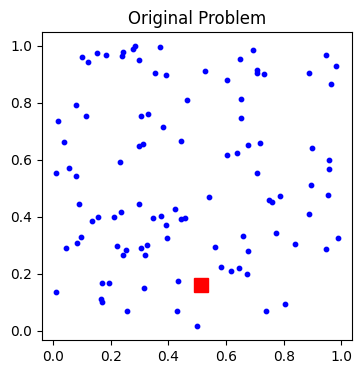

In [22]:
# Visualize the original problem
original_locs = td["locs"][batch_idx].cpu().detach()

# Plotting
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the cities
ax.scatter(original_locs[1:, 0], original_locs[1:, 1], c='b', s=10)

# Plot the depot
ax.plot(original_locs[0, 0], original_locs[0, 1], 'rs', markersize=10)

# Adding info
ax.set_title("Original Problem")
plt.show()

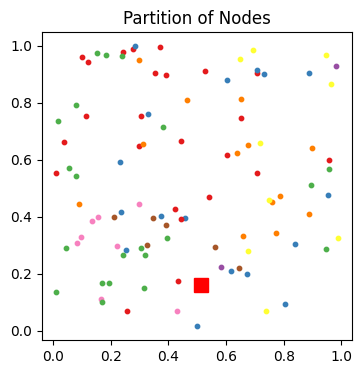

In [23]:
# Visualize the partition
nodes = out["partition"][case_idx].cpu().detach() # [n_partitions, n_nodes]
original_locs = td["locs"][batch_idx].cpu().detach() # [n_nodes, 2]
original_locs_expand = torch.repeat_interleave(original_locs.unsqueeze(0), nodes.size(0), dim=0) # [n_partitions, n_nodes, 2]
partition_locs = gather_by_index(original_locs_expand, nodes) # [n_partitions, n_nodes, 2]

# Plotting
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the cities
for partition_idx in range(partition_locs.shape[0]):
    color = cm.Set1(partition_idx%8)
    ax.scatter(partition_locs[partition_idx, :, 0], partition_locs[partition_idx, :, 1], color=color, s=10)

# Plot the depot
ax.plot(original_locs[0, 0], original_locs[0, 1], 'rs', markersize=10)

# Adding info
ax.set_title("Partition of Nodes")
plt.show()

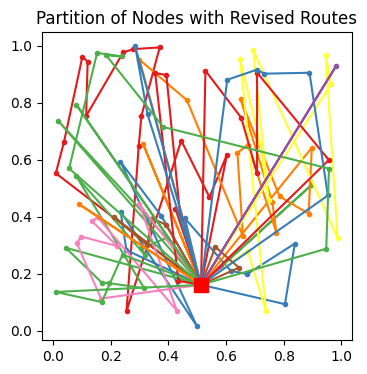

In [25]:
# Visualize the reviser result for partitions
reviser_actions = out["revised_actions"].cpu().detach() # [B*S*P, L]
reviser_actions_reshape = reviser_actions.view(batch_size*n_samples, n_partitions, -1) # [B*S, P, L]: should be the same size as out["partition"]
partition_actions = out["partition"].cpu().detach() # [B*S, P, L]

partition_actions_revised = torch.gather(partition_actions, -1, reviser_actions_reshape) # [B*S, P, L]
partition_actions_revised_sample = partition_actions_revised[case_idx] # [P, L]

# Adding the depot at the first place of each sequence
partition_actions_revised_sample = torch.cat([torch.zeros(partition_actions_revised_sample.size(0), 1).int(), partition_actions_revised_sample], dim=1)

original_locs = td["locs"][sample_idx].cpu().detach() # [n_nodes, 2]
original_locs_expand = torch.repeat_interleave(original_locs.unsqueeze(0), partition_actions_revised_sample.size(0), dim=0) # [P, n_nodes, 2]
locs_partition_revised = gather_by_index(original_locs_expand, partition_actions_revised_sample) # [P, L, 2]

fig, ax = plt.subplots(figsize=(4, 4))

# Plot the cities
for partition_idx in range(n_partitions):
    color = cm.Set1(partition_idx%8)
    ax.plot(locs_partition_revised[partition_idx, :, 0], locs_partition_revised[partition_idx, :, 1], color=color, marker='o', markersize=3)

# Plot the depot
ax.plot(original_locs[0, 0], original_locs[0, 1], 'rs', markersize=10)

# Adding info
ax.set_title("Partition of Nodes with Revised Routes")
plt.show()

### Trainer

The RL4CO trainer is a wrapper around PyTorch Lightning's `Trainer` class which adds some functionality and more efficient defaults

In [26]:
num_loc = 50
n_samples = 10

# Create the environment
cvrp_env = CVRPEnv(generator_params={"num_loc": num_loc}) 

# Init the GLOP model with loaded revisers
model = GLOP(
    env=cvrp_env, 
    revisers=reviser_list,
    n_samples=n_samples,
    baseline="shared",
    batch_size=32,
    train_data_size=10_000,
    val_data_size=1_000,
    optimizer_kwargs={"lr": 1e-4},
) 

trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

trainer.fit(model)

/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0:   9%|▉         | 28/313 [00:11<02:01,  2.35it/s, v_num=0, train/reward=-23.6, train/loss=0.979] 

/home/cbhua/miniconda/envs/rl4co-private/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
